# <img src="https://raw.githubusercontent.com/inlab-geo/cofi/main/docs/source/_static/latte_art_cropped.png" width="5%" style="vertical-align:bottom"/> Workshop Notebook 3 (ERT)

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/workshop-2022/blob/main/notebooks/3_electrical_resistivity_tomography.ipynb)

In this notebook, let's look at the an electrical resistivity tomography problem.

## Learning outcomes (this might need rewording..)

- CoFI's **ease to switch** between fundamentally different inference approaches
- CoFI's **expandability**
- CoFI's **example-driven** feature

# Context

Electrical resistivity tomography is the inversion of measurements of apparent subsurface electrical resistivties between electrodes placed at the surface. It is frequently employed for the detection and delination of groundwater resources, clay formation and to monitor pollution plumes.

Here we illustrate the expandability of CoFI by combining a mature python library for geophysical inversion that implement one inversion method for ERT (PyGIMLI https://www.pygimli.org/) with the iterative non linear solvers we have made available in CoFI. That is the forward problem will be solved using PyGIMLI while the inverse problem will be solved using CoFI.

The objective function we are minimising is given as

$
\Psi(\mathbf{m}) = (\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} C_{d}^{-1}(\mathbf{d} -\mathrm{f}(\mathbf{m}))^{\mathrm{T}} + \lambda \mathbf{m}^{T} W^{\mathrm{T}} W \mathbf{{m}}$
$

where $d$ represents the data vector here measured apparent resistivties, $\mathrm{f}(\mathbf{m})$ is the model prediction, $C_d^{-1}$ is the inverse of the data covariance matrix, $W$ the model smoothing matrix and $\mathbf{m}$ the model vector and $\lambda$ a regularisation factor

The model update is then given as

$
\begin{equation} \Delta \mathbf{m}= (\underbrace{\mathbf{J}^T \mathbf{C}_d^{-1} \mathbf{J}+\lambda W^{T} W}_{\mathbf{Hessian}})^{-1}
(\underbrace{ \mathbf{J}^T\mathbf{C}_d^{-1} 
(\mathbf{d}-\mathrm{f}(\mathbf{m}))+\lambda W^{T} W \mathbf{m}}_{\mathbf{Gradient}}),
\end{equation} 
$

where $J$ represents the Jacobian

For mildly non-linear problems the full Newton step can be used to update the model. For more non-linear objective functions it makes sense to employ a line search or a trust region method to achieve better convergence that is fewer evaluations of the Jacobian and ultimately objective function. Successful inversion also relies on the objective function being smooth and predictable for apparent resistivty data it is advantageosu to convert measuremnts and mdoel parameters to scale logarithmically to obtian a smoother and more predictable objective function when compared with using the unscaled data and unscaled mode parameters (https://academic.oup.com/gji/article/201/3/1765/776058)


In [1]:
# Environment setup (uncomment code lines below)

# !pip install -U cofi cofi-espresso

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

## Interfacing to PyGIMLI

PyGIMLI provides all the functionality to given a model compute the apparent resitvties and Jacobian as well as invert the data. With CoFI our goal is to never to reinvent the wheel thus is when interfacing with PyGIMLI we will

- Use PyGIMLI's functionality to plot the model and data
- Use PyGIMLI's capabilities to compute the model response and Jacobian

To achieve this we first define a set of utility functions that will facilitate interfacing to PyGIMLI.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli
from pygimli.physics import ert
from pygimli import meshtools

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

In [3]:
############# Utility functions using PyGIMLi ##############################################

# Dipole Dipole (dd) measuring scheme
def survey_scheme(start=0, stop=50, num=51, schemeName="dd"):
    scheme = ert.createData(elecs=np.linspace(start=start, stop=stop, num=num),schemeName=schemeName)
    return scheme

# true geometry, forward mesh and true model
def model_true(scheme, start=[-55, 0], end=[105, -80], anomaly_pos=[10,-7], anomaly_rad=5):
    world = meshtools.createWorld(start=start, end=end, worldMarker=True)
    for s in scheme.sensors():          # local refinement 
        world.createNode(s + [0.0, -0.1])
    conductive_anomaly = meshtools.createCircle(pos=anomaly_pos, radius=anomaly_rad, marker=2)
    geom = world + conductive_anomaly
    rhomap = [[1, 200], [2,  50],]
    mesh = meshtools.createMesh(geom, quality=33)
    return mesh, rhomap

# PyGIMLi ert.ERTManager
def ert_manager(data, verbose=False):
    return ert.ERTManager(data, verbose=verbose, useBert=True)

# inversion mesh
def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    # print("model size", inv_mesh.cellCount())   # 1031
    ert_mgr.setMesh(inv_mesh)
    return inv_mesh

# inversion mesh rectangular (the above is by default triangular)
def inversion_mesh_rect(ert_manager):
    x = np.linspace(start=-5, stop=55, num=40)
    y = np.linspace(start=-20,stop=0,num=10)
    inv_mesh = pygimli.createGrid(x=x, y=y, marker=2)
    inv_mesh = pygimli.meshtools.appendTriangleBoundary(inv_mesh, marker=1, xbound=50, ybound=50)
    # print("model size", inv_mesh.cellCount())    # 1213
    ert_manager.setMesh(inv_mesh)
    return inv_mesh

# PyGIMLi ert.ERTModelling
def ert_forward_operator(ert_manager, scheme, inv_mesh):
    forward_operator = ert_manager.fop
    forward_operator.setComplex(False)
    forward_operator.setData(scheme)
    forward_operator.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_operator

# regularization matrix
def reg_matrix(forward_oprt):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

# initialise model
def starting_model(ert_mgr, val=None):
    data = ert_mgr.data
    start_val = val if val else np.median(data['rhoa'].array())     # this is how pygimli initialises
    start_model = np.ones(ert_mgr.paraDomain.cellCount()) * start_val
    start_val_log = np.log(start_val)
    start_model_log = np.ones(ert_mgr.paraDomain.cellCount()) * start_val_log
    return start_model, start_model_log

# convert model to numpy array
def model_vec(rhomap, fmesh):
    model_true = pygimli.solver.parseArgToArray(rhomap, fmesh.cellCount(), fmesh)
    return model_true

# Problem definition

Our example is centred around invertingof dipole dipole measurements of apparaent resistivites in 2D with a circular shaped low resistivtiy anomaly. 

Text(0.5, 1.0, 'True model')

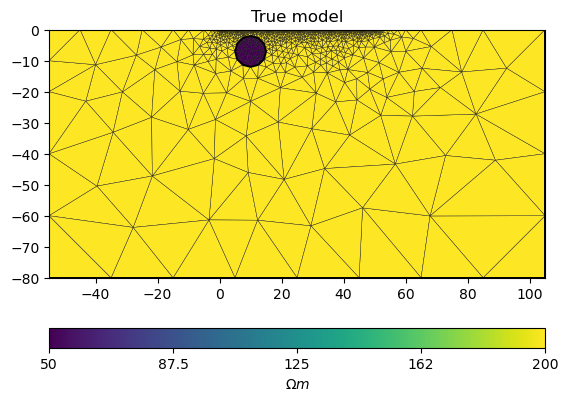

In [4]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

The model respons has been previously computed with pygimly and noise has been added with the magnitude of the noise depending on the dipole dipole spearation.

In [5]:
# load data and covariance matrix
log_data = np.loadtxt("ert_data_log.txt")
data_cov_inv = np.loadtxt("ert_data_cov_inv.txt")

# create PyGIMLi's ERT manager
ert_mgr = ert_manager("ert_data.dat")

Text(0.5, 1.0, 'Provided data')

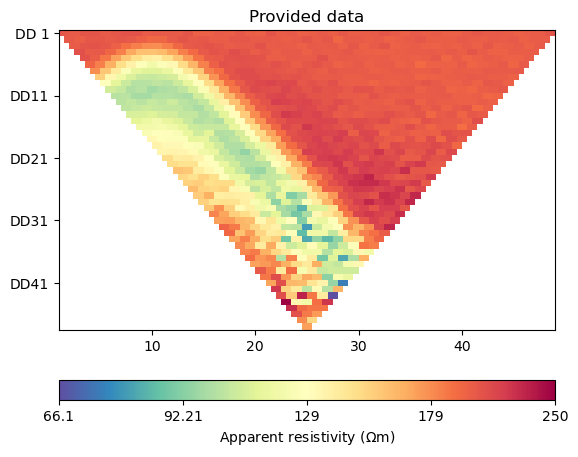

In [6]:
# plot data
data = ert_mgr.data
ax = ert.show(data)
ax[0].set_title("Provided data")

Solving an ERT forward poblem requries the definiton obuncday nodes or ghost nodes around the model. This is all handled by PyGIMLI and the model vector for the purposed of the inversion ared the cells plotted in yellow

19/10/22 - 14:32:19 - pyGIMLi - INFO - Found 2 regions.
19/10/22 - 14:32:19 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

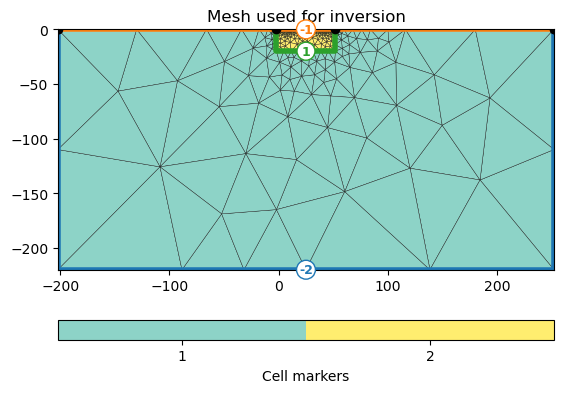

In [7]:
inv_mesh = inversion_mesh(ert_mgr)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

19/10/22 - 14:32:20 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
19/10/22 - 14:32:20 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
19/10/22 - 14:32:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/10/22 - 14:32:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

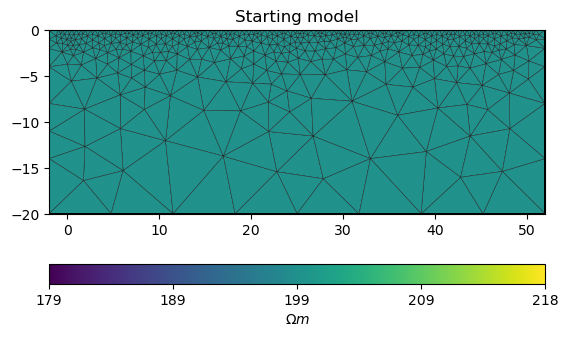

In [8]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_mgr, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_mgr)
ax = pygimli.show(ert_mgr.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

In [9]:
############# Functions provided to CoFI ##############################################

## Note: all functions below assume the model in log space!

def get_response(model, forward_operator):
    return np.log(np.array(forward_operator.response(np.exp(model))))

def get_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    return residual

def get_jacobian(model, forward_operator):
    response = get_response(model, forward_operator)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac

def get_jac_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac, residual

def get_data_misfit(model, log_data, forward_operator, data_cov_inv=None):
    model = np.squeeze(np.asarray(model))
    residual = get_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    return np.abs(residual.T @ data_cov_inv @ residual)

def get_regularization(model, Wm, lamda):
    model = np.exp(model)
    return lamda * (Wm @ model).T @ (Wm @ model)

def get_objective(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    data_misfit = get_data_misfit(model, log_data, forward_operator, data_cov_inv)
    regularization = get_regularization(model, Wm, lamda)
    obj = data_misfit + regularization
    return obj

def get_gradient(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac, residual = get_jac_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    data_misfit_grad =  - residual.T @ data_cov_inv @ jac
    regularization_grad = lamda * Wm.T @ Wm @ np.exp(model)
    return data_misfit_grad + regularization_grad

def get_hessian(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac = get_jacobian(model, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    hess = jac.T @ data_cov_inv @ jac + lamda * Wm.T @ Wm
    return hess

In [10]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularization(get_regularization, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

# Things to experiment with 

- Full Newton Step to illustrate the poor convergence of it
- Provide information form the solvers about number of function/jacobian evaluations 
- Other Approaches to try
    - Trust region method
    - Conjugate Gradient
    - Line search method



# Questions

- What is model change is it $|\Delta m|$ what is objective change is it $|\Delta d|$ I would just make clear what it it is 

In [11]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "matrix solvers": [
        "cofi.simple_newton"
    ],
    "sampling": []
}


# Full Newton step

19/10/22 - 14:32:20 - Core - WARNING -  data contains no K-factors but we calculate them  analytically for the response call


Iteration #0, objective function value: 229.71418345445022
Iteration #1, objective function value: 224.79875151411954
Iteration #2, objective function value: 220.36237268797797
Iteration #3, objective function value: 215.90570020911184
Iteration #4, objective function value: 211.61775613255452
Iteration #5, objective function value: 207.3825693018691
Iteration #6, objective function value: 203.263958279641
Iteration #7, objective function value: 199.21577271919293
Iteration #8, objective function value: 195.26522476018053
Iteration #9, objective function value: 191.38884081936882

Number of objective function evaluations: 10
Number of gradient function evaluations: 10
Number of hessian function evaluations: 10


Text(0.5, 1.0, 'Provided data')

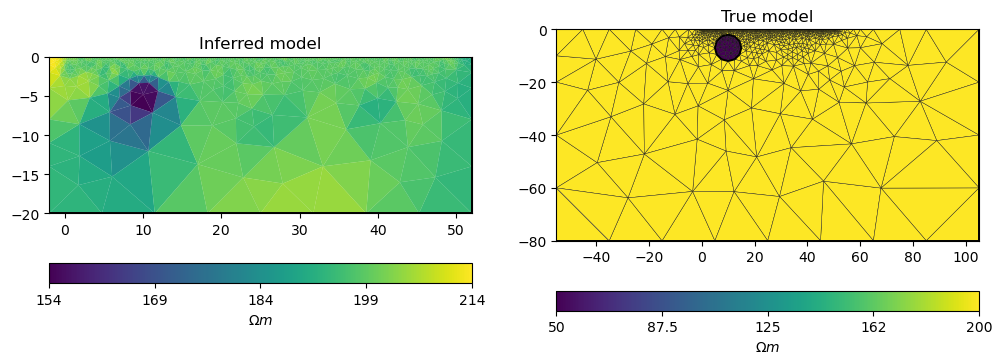

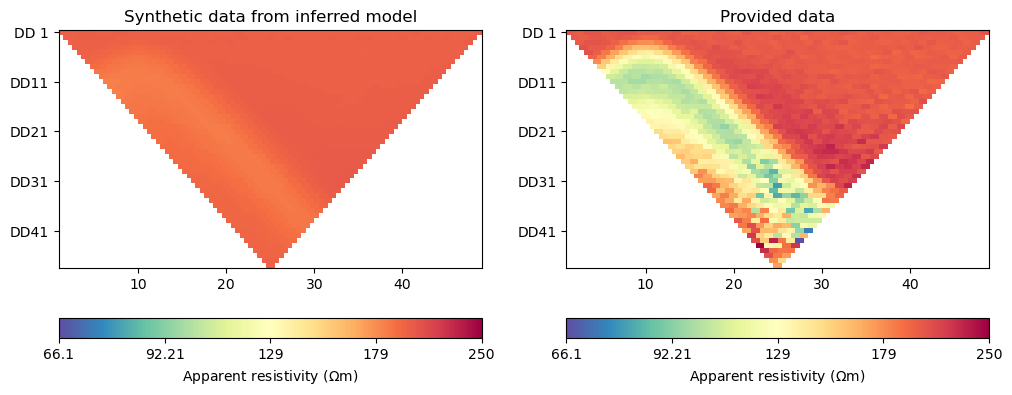

In [12]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("cofi.simple_newton")
inv_options_scipy.set_params(max_iterations=10, step_length=0.01)
class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")
print(f"Number of hessian function evaluations: {inv_result.n_hess_evaluations}")

# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

# Trust region method

Iteration #0
  objective value: 157.50708172346378
Iteration #1
  model change: 2.0
  objective value: 68.94013122104028
Iteration #2
  model change: 2.088598198678278
  objective value: 51.74447637862966
Iteration #3
  model change: 2.235768382076769
  objective value: 32.60775764541545
Iteration #4
  model change: 1.7295706120934409
  objective value: 29.213175185113155
Iteration #5
  model change: 0.0
  objective value: 29.213175185113155
Iteration #6
  model change: 1.000000000004815
  objective value: 16.60616355310069
Iteration #7
  model change: 0.0
  objective value: 16.60616355310069
Iteration #8
  model change: 0.4999999999999974
  objective value: 11.968202845280034
Iteration #9
  model change: 0.0
  objective value: 11.968202845280034

Solver message: Maximum number of iterations has been exceeded.


Text(0.5, 1.0, 'Provided data')

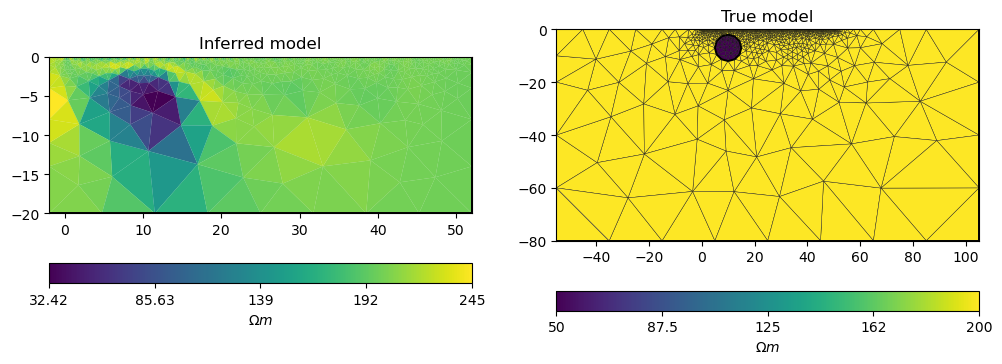

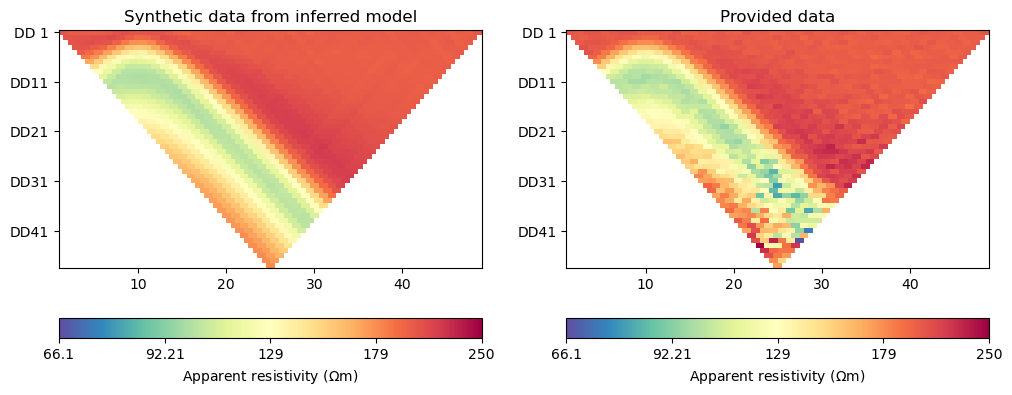

In [13]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-krylov", options={"maxiter": 10})

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nSolver message: {inv_result.message}")


# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

# Conjugate gradient

Iteration #0
  objective value: 69.41232753902358
Iteration #1
  model change: 1.9521920346073645
  objective value: 32.31371502955868
Iteration #2
  model change: 2.00500050501124
  objective value: 31.171940388084867
Iteration #3
  model change: 0.37747947597238996
  objective value: 27.460445378249585
Iteration #4
  model change: 1.2758048179587191
  objective value: 17.691012543494743
Iteration #5
  model change: 0.36975375753519363
  objective value: 13.707069626159713
Iteration #6
  model change: 0.2278464702539639
  objective value: 11.47155839527201
Iteration #7
  model change: 0.7119892706126505
  objective value: 10.779768258980473
Iteration #8
  model change: 0.24671253819187977
  objective value: 9.618581002649401
Iteration #9
  model change: 0.1902053798830444
  objective value: 8.486752716367635

Solver message: Warning: Maximum number of iterations has been exceeded.


Text(0.5, 1.0, 'Provided data')

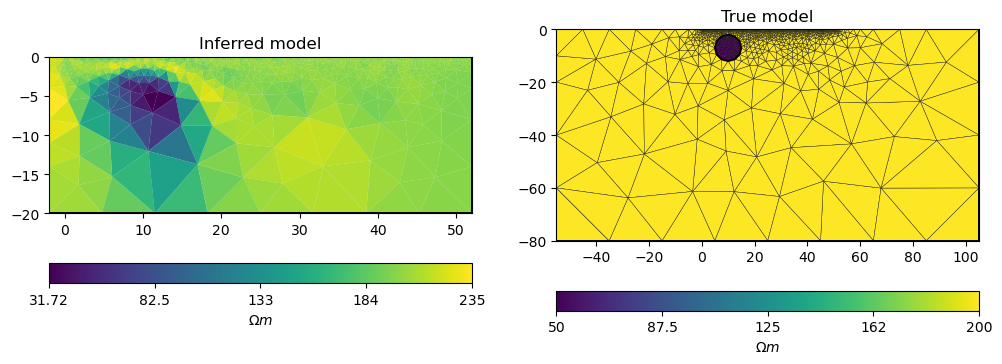

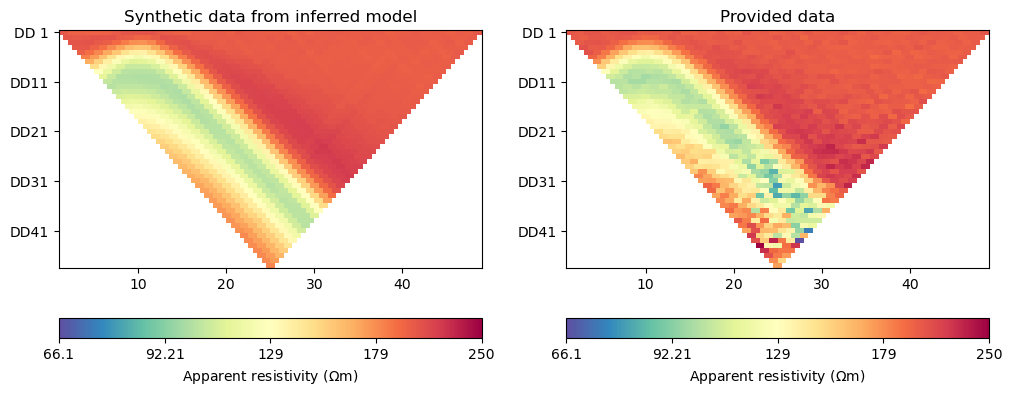

In [14]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="newton-cg", options={"maxiter": 10})

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

inv_options_scipy.set_params(callback=CallbackFunction())

inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nSolver message: {inv_result.message}")


# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_title("True model")

# plot the data
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

---
## Watermark

In [15]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev17
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
